# Tutorial III: Fully connected NNs

<p>
Bern Winter School on Machine Learning, 2023<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected neural network to perform handwritten digit recognition using pytorch

## 1. Load necessary libraries



In [ ]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader



# URL of the file to download
url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'

# Path where the file will be saved
path = os.path.abspath('.') + '/material.tgz'

# Download the file
response = requests.get(url)
assert response.status_code == 200, "Download failed"
with open(path, 'wb') as file:
    file.write(response.content)

# Check if the path is correct
assert os.path.exists(path), "File not found"

# Extract the tar file
tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

## 2. Training loop

The training as we just saw is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, batches, and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

## 3. Bulding blocks of a neural network

Neural network consists of layers of neurons. Each neuron performs 2 operations.

1. Calculate the linear transformation of the input vector $\mathbf{x}_i$:
$$z_i = \mathbf{w} \cdot \mathbf{x}_i + b = \sum_j {w_j x_{ij}} + b$$ where $\mathbf{w}$ is a weight vector and $b$ - a bias, and $j$ traverses each dimension of the input vector
2. Perform the nonlinear transformation of the result using the activation function $f$ $$y_i = f(z_i)$$

In a fully connected neural network, each layer is a set of N neurons, performing different transformations of the input $\mathbf{x}_i$ of the same layer, now producing an output **vector** $ \mathbf{y} _i = f(\mathbf{z}_i) = f(W\mathbf{x}_i + \mathbf{b})$ now with a bias vector $\mathbf{b}$ and a * *matrix** of weights $W$.

Since the output of each layer constitutes the input to the next layer, we can write for layer $l$: $$\mathbf{x}^l_i = f^{l-1}(\mathbf{W}^{ l-1} \mathbf{x}^{ l-1}_i + \mathbf{b}^{l-1})$$ where $\mathbf{x}_i^{l=0}$ is the vector d 'network input for data point $i$.



<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/MLP.png" alt="drawing" width="50%"/>

To simplify building the network, we'll define a helper function, creating neuron layer with given number of outputs:

In [ ]:

class Dense(nn.Module):
    def __init__(self, units, activation=None):
        """
        Fully connected layer.

        Parameters
        ----------
        units : int
            Number of output neurons
        activation : None or callable, optional
            Non-linear activation function (e.g., torch.nn.functional.relu)
        """
        super(Dense, self).__init__()
        self.units = units
        self.activation = activation

        # Initialize the weights and biases
        self.linear = nn.Linear(in_features=units, out_features=units)

    def forward(self, inputs):
        # Apply linear transformation
        outputs = self.linear(inputs)

        # Apply activation function if provided
        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs


In the case of multi-class classification, in the last layer, we can use the *softmax* transformation as a non-linear transformation. The softmax for the $j$th element of $\mathbf{z}_i$ is $$y_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{K} e^{z_{ik}}}$$ where $K$ is the total number of classes.


For example. before softmax $$[1.0, 2.0, 3.0, \mathbf{4.0} ]$$ and after: $$[0.0321, 0.0871, 0.2369, \mathbf{0.6439}]$$ (now the sum is equal to one)

We can also now compare the fundamental truth which could be $$[0,0,0,\mathbf{1}]$$ That is to say that class 4 is the good class and that the network predicted correctly.



The **optimization/loss function** in multiclass classification problems is multiclass cross-entropy:
$$\mathcal{L}_i = - \sum_{k=1}^K y^*_{ik} \log(y_{ik})$$ where $y^*_{ik}$ is the $k $th component of the unique true label vector $\mathbf{y}^*_i$, and $y_{ik}$ is the $k$th component of the predicted probability vector $\mathbf{y}_i$.

$$[0.0321, 0.0871, 0.2369, \mathbf{0.6439}] = [y_{i1}, y_{i2}, y_{i3}, y_{i4}]$$

## 4. Structure of a neural network

In [ ]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MyModel, self).__init__()
        # Layer 1: 10 inputs -> 4, with sigmoid activation
        self.l1 = nn.Linear(n_input, n_hidden)

        # Layer 2: 4 inputs -> n_output, with softmax activation
        self.l2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # Apply first layer and sigmoid activation
        x = torch.sigmoid(self.l1(x))

        # Apply second layer
        l2_output = self.l2(x)

        # Apply softmax activation
        l2_softmax = F.softmax(l2_output, dim=1)

        # Prediction: argmax for classification
        pred = torch.argmax(l2_softmax, dim=1)
        return l2_softmax, pred


## 5. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.

Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: torch.flatten(x))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.6MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.58MB/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


 Let's take a look at some of the example images

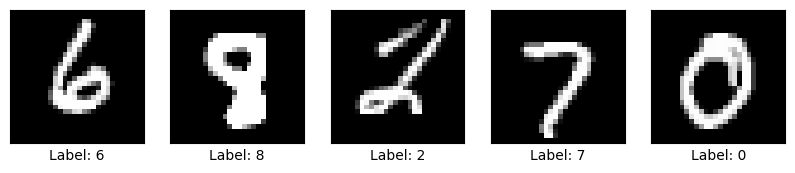

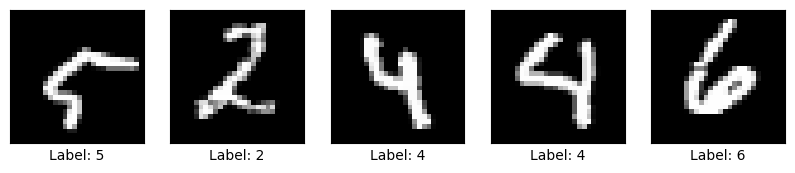

In [ ]:
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Reshape the flattened images back to 28x28 for display
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        plt.xlabel('Label: {}'.format(labels[i].item()))
    plt.show()

# Function to get random images and labels from a dataset
def get_random_images(loader, num_images=5):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    indices = list(range(len(images)))
    random_indices = random.sample(indices, num_images)
    random_images = images[random_indices]
    random_labels = labels[random_indices]
    return random_images, random_labels

# Get random images and labels from the training set
random_images, random_labels = get_random_images(trainloader, num_images=5)
# Show images
show_images(random_images, random_labels, num_images=5)

# and for the test set:
random_images, random_labels = get_random_images(testloader, num_images=5)
show_images(random_images, random_labels, num_images=5)



Check out the dimensions of the data

In [ ]:

# Inspect the dimensions of the sample elements
print("Shape of the images:", random_images.shape)
print("Shape of the labels:", random_labels.shape)
print(random_labels)

Shape of the images: torch.Size([5, 784])
Shape of the labels: torch.Size([5])
tensor([5, 2, 4, 4, 6])


## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image dims (flattened), size. Output - by number of classes, 10 in our case.

In [ ]:
n_hidden = 10
model = MyModel(n_input=784, n_hidden=n_hidden, n_output=10)  # 784 input features for 28x28 images, 10 output classes

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.cuda.is_available()

False

Defining a training function:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, trainloader, criterion, optimizer):
    model.train()
    model.to(device)
    running_loss = 0.0
    num_batches = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # reset gradients
        output, _ = model(images)
        loss = criterion(output, labels)
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        running_loss += loss.item()
    return running_loss / len(trainloader)

Defining a testing function:

In [ ]:
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    model.to(device)
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output, _ = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
    return running_loss / len(testloader)

Training the model

In [ ]:
import time

num_epochs = 2
train_losses = []
test_losses = []
model.to(device)
print('Training....')
for epoch in range(num_epochs):
    start = time.time()
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss = test(model, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    end = time.time()
    print('Epoch took:', end-start)

Training....
Epoch 1/2, Train Loss: 2.0429, Test Loss: 1.8728
Epoch took: 19.72158694267273
Epoch 2/2, Train Loss: 1.7759, Test Loss: 1.6843
Epoch took: 18.621240615844727


Visualize the loss curves

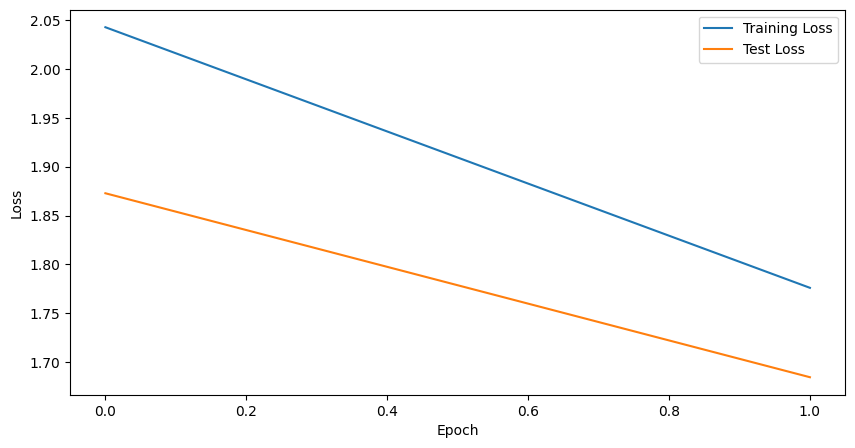

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

Evaluate network performance using a basic accuracy metric:

$$\mbox{Acc}= \frac{1}{N}\sum_{i=1}^N \mathbb{I}(y_i = y^*_i)$$

where $\mathbb{I}()$ is the indicator function.


Also investigate what an incorrect prediction looks like...

In [ ]:

def get_predictions(model, loader):
    model.eval()
    model.to(device)
    predictions = []
    all_labels = []
    images_list = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Fix variable names

            output, _ = model(images)
            pred = output.argmax(dim=1)

            predictions.extend(pred.cpu().tolist())  # Move to CPU before converting to list
            all_labels.extend(labels.cpu().tolist())  # Move to CPU before converting to list
            images_list.extend(images.cpu())  # Move images to CPU to avoid device mismatch

    return predictions, all_labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8690


Aggregate a correct and incorrect example and visualize:

First incorrect digit is at index: 15


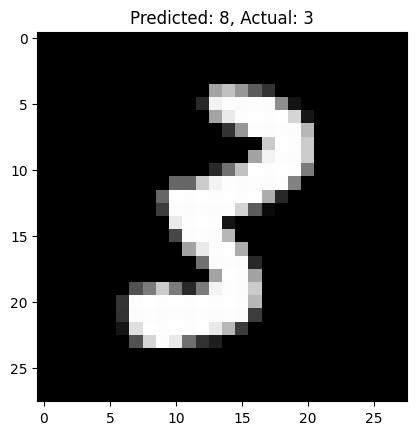

First correct digit is at index: 7


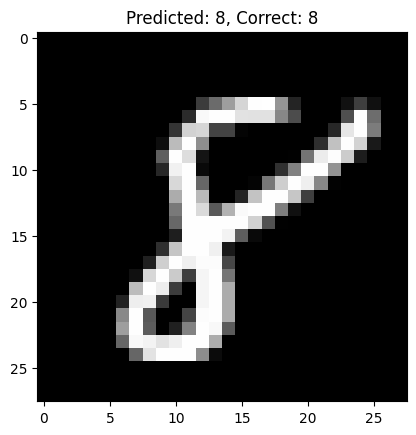

In [ ]:

# Find the index of the first incorrect and correct prediction
correct = [pred == label for pred, label in zip(predictions, labels)]
wrong_idx = [i for i, correct in enumerate(correct) if not correct][1]
correct_idx = [i for i, correct in enumerate(correct) if correct][7]

# Function to display an image
def display_image(image, title):
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first incorrect digit (if any incorrect are found)
if wrong_idx is not None:
    print(f"First incorrect digit is at index: {wrong_idx}")
    display_image(images_list[wrong_idx], f"Predicted: {predictions[wrong_idx]}, Actual: {labels[wrong_idx]}")
else:
    print("No incorrect predictions found")

# Display the first correct digit (if any correct are found)
if correct_idx is not None:
    print(f"First correct digit is at index: {correct_idx}")
    display_image(images_list[correct_idx], f"Predicted: {predictions[correct_idx]}, Correct: {labels[correct_idx]}")
else:
    print("No correct predictions found")

## 7. Visualizing the Parameters

The learned model parameters W1 are a matrix of weights that show importance of each input pixel (784) for each of the 10 outputs.

torch.Size([10, 784]) torch.Size([10])


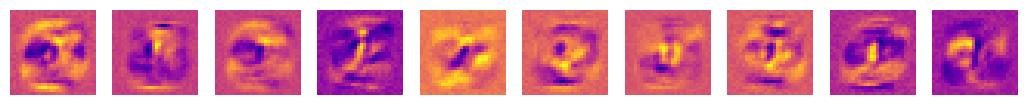

In [ ]:
w1, b1 = model.l1.weight.data, model.l1.bias.data
print(w1.shape, b1.shape)

w1_reshaped = w1.view(n_hidden, 28, 28)  # Adjust the view dimensions as per your layer's configuration

# Plotting the weights
_, axs = plt.subplots(1, n_hidden, figsize=(13, 5))
for i in range(10):
    axs[i].imshow(w1_reshaped[i].cpu().numpy(), cmap='plasma', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')
plt.show()

Here we classify images into 10 classes. But think of it: does the network know, or need to know that those were images? For the network each image is just a 784 values. And it finds that there is a patten.

Same way one can feed any other bunch of numbers, and the network will try it's best to fugure out a relation pattern between those.






## 7. Exercise 1

Build a network with two layers, first with `tf.nn.relu` ReLU activation and 1500 neurons and second one with 10 and softmax activation. Start with `learning_rate` of 0.001 and find optimal value.

## 8. Gradients visualization

We will display several images, and corresponding gradients of maximal output activation, as well as all activations. This might help better understand how our network processes the imput data.

In [ ]:
model.eval()
grads_all_classes = []


# The code uses torch.autograd.grad to compute the gradients of the model's predictions with respect to the input image.
# This essentially answers the question, "How does changing each pixel in the input image affect the model's confidence in its prediction for each class (digit)?"

# For each digit class (0 to 9), the code computes a separate gradient map.
# It does so by setting grad_outputs to a tensor that is all zeros except for a one at the current class's position.
# This way, the computed gradient reflects how much each pixel in the input image contributes to the model's prediction for that specific class.

dataiter = iter(trainloader)
images, labels = next(dataiter)

# Choose an index and select a single image and label
idx = 42
print(len(images))
inp_v = images[idx:idx+1]  # Selecting the image
img = inp_v.squeeze()  # The original 2D image for display

# Enable gradients for input
inp_v.requires_grad = True


# autograd.grad(outputs=preds): The outputs argument specifies the tensors for which the gradient will be computed.
# In this context, preds are the predictions made by the model for the given input image.
# These predictions are a tensor where each element corresponds to the model's confidence for each class.
# inputs=inp_v: The inputs argument specifies the tensors with respect to which the gradient will be computed.
# Here, inp_v is the input image tensor. You're essentially asking,
# "How does the input image need to change to maximize the model's confidence in each class?"
# grad_outputs=grad_outputs: This specifies the gradient of the output.
# In this case, grad_outputs is a tensor of the same shape as preds but with zeros everywhere except for a one at the index of the current class. This tensor indicates that you want to compute the gradient with respect to only one specific class at a time.
# create_graph=True: This argument, when set to True, tells PyTorch to construct a computational
# graph of the gradient computation itself, which allows you to then compute higher-order derivatives.
# It's essential when you need to compute gradients of gradients (second derivatives).

# Forward pass and compute gradients
model.eval()
with torch.set_grad_enabled(True):
    preds = model(inp_v.to(device))[0]  # Assuming the model returns a tuple (output, argmax)
    print(preds.shape)
    for i in range(preds.size(1)):  # Iterate over each class
        print(f'class: {i}')
        grad_outputs = torch.zeros_like(preds)
        grad_outputs[0, i] = 1
        grads = torch.autograd.grad(outputs=preds, inputs=inp_v, grad_outputs=grad_outputs, retain_graph=True)[0]
        grads_all_classes.append(grads)

# Stack all gradients and reshape to desired format
grads_stacked = torch.stack(grads_all_classes).view(preds.size(1), 28, 28).detach().cpu().numpy()



64
torch.Size([1, 10])
class: 0
class: 1
class: 2
class: 3
class: 4
class: 5
class: 6
class: 7
class: 8
class: 9


Each of the following subplots shows the gradient map for a particular class. These maps can be interpreted as heatmaps indicating which regions of the input image are most critical for the model's prediction of that particular digit.
Brighter areas in a gradient map indicate pixels that, if changed, would have a larger impact on the model's prediction for that class. This can give insights into what features the model is focusing on for each class.


https://medium.com/geekculture/how-visualizations-help-make-sense-of-deep-learning-a408ab00688f


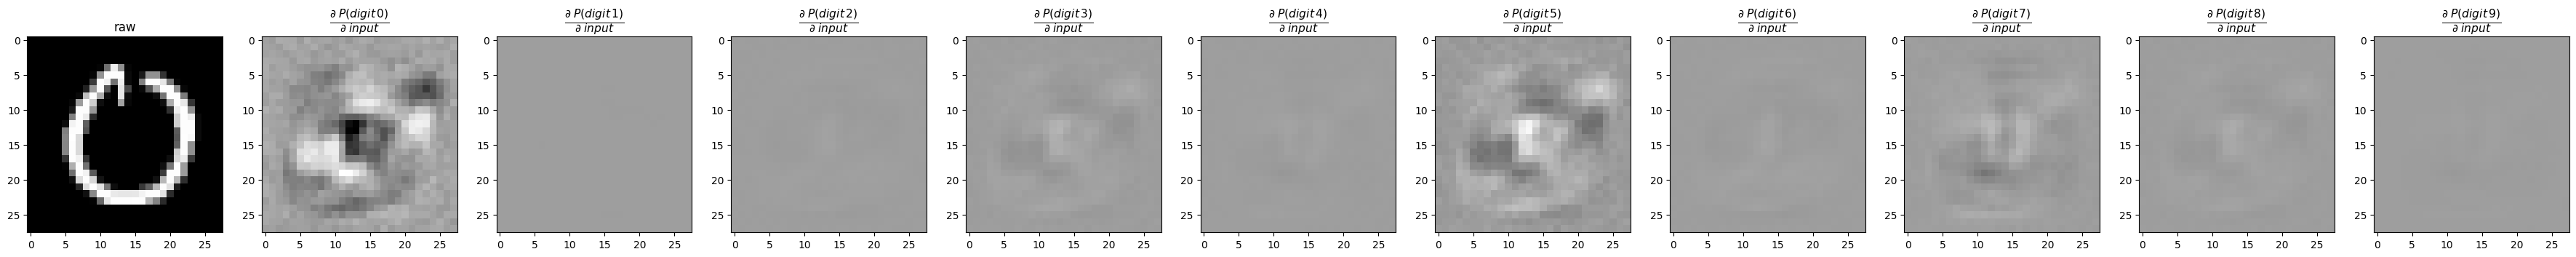

In [ ]:
# Each of the following subplots shows the gradient map for a particular class.
# These maps can be interpreted as heatmaps indicating which regions of the input image are most critical for the model's prediction of that particular digit.
# Brighter areas in a gradient map indicate pixels that, if changed, would have a larger impact on the model's prediction for that class.
# This can give insights into what features the model is focusing on for each class.

# Reshape the flattened image back to 2D for display
img_2d = img.view(28, 28).numpy()

# Plotting
fig, axs = plt.subplots(1, 11, figsize=(4.1 * 11, 4))
axs[0].imshow(img_2d, cmap='gray')  # Display the reshaped original image
axs[0].set_title('raw')
vmin, vmax = grads_stacked.min(), grads_stacked.max()


for i, g in enumerate(grads_stacked):
    axs[i + 1].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
    axs[i + 1].set_title(r'$\frac{\partial\;P(digit\,%d)}{\partial\;input}$' % i, fontdict={'size': 16})

plt.show()

## 9. Exercise 2
### Group 1
Build the network with 3 or more layers. Try to get test accuracy >98.5%.
Better to copy and modify the previous code so that you can compare against the code/results above.


### Group 2

You can repeat the same for a regression problem below: here you will have just 1 output in the last layer, with no activation - to predict continuous unbouded range. You can use the `mse` or `mae` loss. Compare results with a baseline linear / random forest model.

How many parameters does your model have as compared to number of samples?

The example is for housing prices.

Linear(in_features=8, out_features=4, bias=True)
Dropout(p=0.2, inplace=False)
ReLU()
Linear(in_features=4, out_features=4, bias=True)
Dropout(p=0.2, inplace=False)
ReLU()
Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=4, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
)
Linear(in_features=4, out_features=1, bias=True)
MyRegressor(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=4, out_features=4, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=4, out_features=1, bias=True)
)
Epoch 1/2, Train Loss: 0.8134, Test Loss: 0.7750
Epoch 2/2, Train Loss: 0.7927, Test Loss: 0.7665


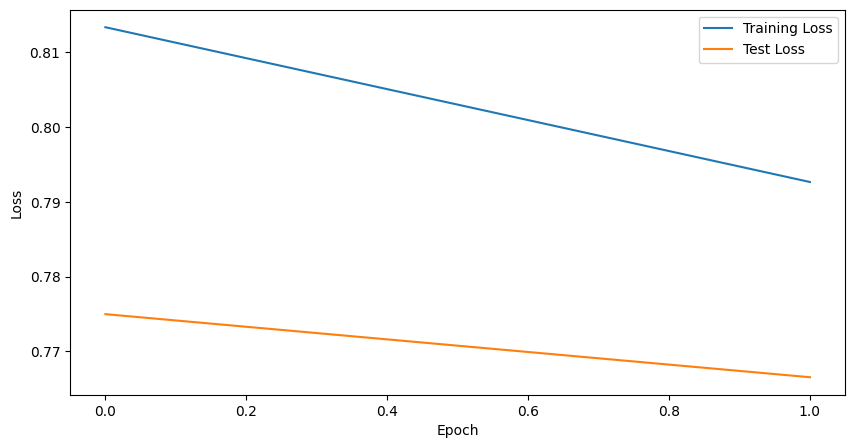

In [ ]:


# Load Housing dataset https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html
cali = fetch_california_housing()
X, y = cali.data, cali.target

#  The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler_y = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Define a batch size
batch_size = 64

# Create DataLoaders for training and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




class MyRegressor(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MyRegressor, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        embeddings = self.layers(x)  # Last hidden layer output
        output = self.output_layer(embeddings)  # Final output layer
        return output, embeddings  # Return both the prediction and the last-layer embeddings



n_input = x_train.shape[1]  # Number of features in the Boston Housing dataset
n_hidden = 4  # Example number of hidden units
n_output = 1  # Regression output


def weights_init(m):
    print(m)
    if isinstance(m, nn.Linear):
      try:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.xavier_normal_(m.bias.data)
      except:
        pass

model = MyRegressor(n_input=n_input, n_hidden=n_hidden, n_output=n_output)

model.apply(weights_init)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 2
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss = test(model, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

In [ ]:

def get_predictions(model, loader):
    model.eval()
    predictions = []
    all_labels = []  # Renaming the list to avoid shadowing
    embeddings = []
    with torch.no_grad():
        for images, batch_labels in loader:  # Rename labels inside the loop
            images, batch_labels = images.to(device), batch_labels.to(device)
            output, embedding = model(images)
            predictions.extend(output.cpu().numpy().tolist())
            all_labels.extend(batch_labels.cpu().numpy().tolist())  # Use renamed variable
            embeddings.extend(embedding.cpu().numpy().tolist())
    return predictions, all_labels, embeddings  # Return the correctly named list


nn_preds, labels, embeddings = get_predictions(model, testloader)

nn_r2 = r2_score(labels, nn_preds)
nn_mse_loss = mean_squared_error(labels, nn_preds)


# Train the random forest model
rf = RandomForestRegressor()
rf.fit(x_train, y_train[:,0])

# Predict on the test set
rf_predictions = rf.predict(x_test)

# Calculate the test loss (MSE)
rf_mse_loss = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print(f'Random Forest Test MSE Loss: {rf_mse_loss:.4f}')
print(f'Random Forest Test R2: {rf_r2:.4f}')
print(f'NN Test MSE Loss: {nn_mse_loss:.4f}')
print(f'NN Test R2: {nn_r2:.4f}')




Random Forest Test MSE Loss: 0.1953
Random Forest Test R2: 0.8050
NN Test MSE Loss: 1.0088
NN Test R2: -0.0076


In [ ]:
# as an exercise you could also try a more complex network, and to extract the final layer's
# embeddings, and then to train a random forest on this embedding.

nn_preds = np.array(nn_preds)
labels = np.array(labels)
embeddings = np.array(embeddings)

rf_embedding = RandomForestRegressor()
rf_embedding.fit(embeddings, labels.ravel())

rf_embedding_predictions = rf_embedding.predict(embeddings)

# Calculate the test loss (MSE) for embedding-based RF
rf_embedding_mse_loss = mean_squared_error(labels, rf_embedding_predictions)
rf_embedding_r2 = r2_score(labels, rf_embedding_predictions)

# Print results
print(f'Random Forest Test MSE Loss (original features): {rf_mse_loss:.4f}')
print(f'Random Forest Test R2 (original features): {rf_r2:.4f}')
print(f'Random Forest Test MSE Loss (NN embeddings): {rf_embedding_mse_loss:.4f}')
print(f'Random Forest Test R2 (NN embeddings): {rf_embedding_r2:.4f}')
print(f'NN Test MSE Loss: {nn_mse_loss:.4f}')
print(f'NN Test R2: {nn_r2:.4f}')

Random Forest Test MSE Loss (original features): 0.1953
Random Forest Test R2 (original features): 0.8050
Random Forest Test MSE Loss (NN embeddings): 0.3955
Random Forest Test R2 (NN embeddings): 0.6050
NN Test MSE Loss: 1.0088
NN Test R2: -0.0076


In [ ]:
}